In [1]:
.L ../libAmBe.so

In [2]:
test();

Hello World !


In [3]:
std::unique_ptr<TFile> G4File {TFile::Open("../dataset/ambe2022.root")};

In [4]:
std::unique_ptr<TTree> mainTree{G4File->Get<TTree>("T5")};
mainTree->AddFriend("T1", "../dataset/ambe2022.root");
mainTree->AddFriend("T9", "../dataset/ambe2022.root");
mainTree->AddFriend("A", "../dataset/EQuenched/ambe2022.root");
ROOT::RDF::RNode df = ROOT::RDataFrame{*mainTree};
double Nt = df.Count().GetValue();

# CE events selection
TODO

In [5]:
double Ncet = df.Filter("CEReachPvt").Count().GetValue();

In [6]:
df.Filter("!is_event").Display({"pdg", "A.chainMaskT5", "E_quenched"}, 50, 50)->Print()

+-----+------------+---------------+---------------+
| Row | pdg        | A.chainMaskT5 | E_quenched    | 
+-----+------------+---------------+---------------+
| 1   | 2112       | 0             | 0.019963543   | 
|     | 2112       | 0             | 0.0091157907  | 
|     | 2112       | 0             | 0.00045830944 | 
|     | 2112       | 0             | 6.0026724e-06 | 
|     | 2112       | 0             | 1.3009620e-07 | 
|     | 1000020040 | -1            | 2.0542633     | 
|     | 1000010030 | -1            | 2.7268907     | 
|     | 2212       | 0             | 0.081663204   | 
+-----+------------+---------------+---------------+
| 2   | 2112       | 0             | 0.011947218   | 
|     | 2112       | 0             | 9.8539947e-08 | 
|     | 2112       | 0             | 3.0683815e-08 | 
|     | 1000020040 | -1            | 2.0550252     | 
|     | 1000010030 | -1            | 0.59106032    | 
|     | 2212       | 0             | 0.0074478170  | 
|     | 2212       | 0         

# Blind selection

ROOT::RDF::RNode dfs = df.Define("nME", "EpvtRankedCube[3.7 < EpvtRankedCube && EpvtRankedCube < 4.6].size()");
dfs = dfs.Define("_lowCubeMask", "0.1 < EpvtRankedCube && EpvtRankedCube < 0.5");
dfs = dfs.Define("nLE", "EpvtRankedCube[_lowCubeMask].size()");
dfs = dfs.Define("Selection", "ROOT::RVec<int> {-1, -1}");
dfs = dfs.Redefine("Selection", "Selection[0] = nME > 0? volidRankedCube[3.7 < EpvtRankedCube && EpvtRankedCube < 4.6][0]: -1; return Selection;");
dfs = dfs.Define("CEGammasDist", "Selection[0] != -1? euclidDist(Selection[0], volidRankedCube[_lowCubeMask]): ROOT::RVec<double>{-1}");
dfs = dfs.Define("_indexG", "CEGammasDist[0] != -1 ? indexMax(EpvtRankedCube[_lowCubeMask][CEGammasDist <= 2]): -1");
dfs = dfs.Redefine("Selection", "Selection[1] = _indexG != -1 ? volidRankedCube[_lowCubeMask][CEGammasDist <= 2][0]: -1; return Selection;");


In [7]:
ROOT::RDF::RNode dfs = df.Define("_MEmask", "0. < EpvtRankedCube && EpvtRankedCube < 4.6");
dfs = dfs.Filter("0 < EpvtRankedCube[_MEmask].size()");

In [8]:
dfs.Display({"A.EpvtRankedCube", "pdg", "A.chainMaskT5", "E_quenched"}, 50, 50)->Print()

+-----+------------------+------------+---------------+---------------+
| Row | A.EpvtRankedCube | pdg        | A.chainMaskT5 | E_quenched    | 
+-----+------------------+------------+---------------+---------------+
| 0   | 0.68091790       | 2112       | 0             | 0.024988641   | 
|     | 0.40394600       | 2112       | 0             | 0.049798071   | 
|     | 0.064959501      | 2112       | 0             | 0.046699310   | 
|     | 0.049798071      | 2112       | 0             | 0.0027289221  | 
|     | 0.035163332      | 1000020040 | -1            | 2.0552320     | 
|     | 0.018848802      | 1000010030 | -1            | 2.7259209     | 
|     | 0.0058694691     | 2212       | 0             | 0.018260191   | 
|     | 0.0034195541     | 1000060120 | 0             | 0.0034195541  | 
|     |                  | 1000060120 | 0             | 0.0031405469  | 
|     |                  | 2212       | 0             | 0.010174691   | 
|     |                  | 2212       | 0            

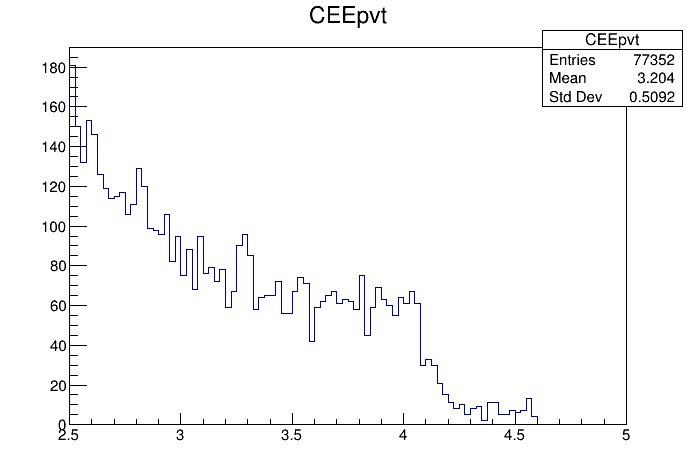

In [9]:
TCanvas c;
auto hist = dfs.Define("EME", "EpvtRankedCube[_MEmask][0]")
    .Filter("!is_event")
    .Histo1D({"CEEpvt", "CEEpvt", 100, 2.5, 5},"EME");
hist->DrawClone();
c.Draw();

In [10]:
dfs = dfs.Define("EME", "EpvtRankedCube[_MEmask][0]")
    .Filter("!is_event")
    .Filter("EME > 3.7");
dfs.Display({"E_quenched", "trackid", "T9.pdg", "T9.trackid", "T9.parentid", "T9.initialEkin"}, 50, 50)->Print()

+------+---------------+---------+------------+------------+-------------+----------------+
| Row  | E_quenched    | trackid | T9.pdg     | T9.trackid | T9.parentid | T9.initialEkin | 
+------+---------------+---------+------------+------------+-------------+----------------+
| 125  | 1.0680316e-05 | 5       | 2112       | 1          | 0           | 6.9853731      | 
|      | 5.6226590e-05 | 7       | 22         | 5          | 1           | 0.0020882913   | 
|      | 0.00062092414 | 6       | 11         | 7          | 5           | 0.00026447000  | 
|      | 5.8380000e-05 | 4       | 11         | 6          | 5           | 0.0017972813   | 
|      | 6.0430000e-05 | 23      | 22         | 4          | 1           | 4.3995985      | 
|      | 0.00011236000 | 22      | 11         | 23         | 4           | 6.0430000e-05  | 
|      | 0.00081933000 | 21      | 11         | 22         | 4           | 0.00011236000  | 
|      | 7.4450000e-05 | 20      | 11         | 21         | 4          

In [11]:
double all = dfs.Count().GetValue()

(double) 1174.0000


In [12]:
double above = dfs.Filter("EME > 4.2").Count().GetValue()

(double) 122.00000


In [13]:
above / all

(double) 0.10391823


In [14]:
double Ns = dfs.Filter("Selection[0] != -1 && Selection[1] != -1").Count().GetValue();

input_line_277:2:28: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                           ^
input_line_277:2:50: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                                                 ^


In [15]:
double Nces = dfs.Filter("Selection[0] != -1 && Selection[1] != -1 && CEReachPvt")
    .Filter("ROOT::VecOps::Any(Selection[0] == volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])").Count().GetValue();

input_line_279:2:45: error: use of undeclared identifier 'Selection'
auto lambda7 = [](const Bool_t var0){return Selection[0] != -1 && Selection[1] != -1 && var0
                                            ^
input_line_279:2:67: error: use of undeclared identifier 'Selection'
auto lambda7 = [](const Bool_t var0){return Selection[0] != -1 && Selection[1] != -1 && var0
                                                                  ^


In [16]:
double eff = Nces / Ncet * 100

(double) 0.0000000


In [17]:
double purity = Nces / Ns * 100

(double) -nan


In [18]:
TCanvas c;
auto hist = dfs.Filter("Selection[0] != -1 && Selection[1] != -1")
    .Define("CandidateEpvt", "EpvtRankedCube[3.7 < EpvtRankedCube && EpvtRankedCube < 4.6][0]")
    .Histo1D({"CandidateEpvt", "CandidateEpvt", 100, 0, 5},"CandidateEpvt");
hist->DrawClone();
c.Draw();

input_line_283:2:28: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                           ^
input_line_283:2:50: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                                                 ^


In [19]:
TCanvas c;
auto hist = dfs.Filter("Selection[0] != -1 && Selection[1] != -1")
    .Filter("!ROOT::VecOps::Any(Selection[0] == volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])")
    .Define("CEEpvt", "EpvtRankedCube[3.7 < EpvtRankedCube && EpvtRankedCube < 4.6][0]")
    .Histo1D({"CEEpvt", "CEEpvt", 100, 0, 5},"CEEpvt");
hist->DrawClone();
c.Draw();

input_line_285:2:28: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                           ^
input_line_285:2:50: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                                                 ^


In [20]:
dfs.Filter("Selection[0] != -1 && Selection[1] != -1")
    .Filter("!ROOT::VecOps::Any(Selection[0] == volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])")
    .Display({"pdg", "A.chainMaskT5", "E_quenched"}, 50, 50)->Print()

input_line_287:2:28: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                           ^
input_line_287:2:50: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                                                 ^


In [21]:
Nt

(double) 196437.00


In [22]:
Ncet

(double) 67805.000


In [23]:
Ns

(double) 0.0000000


In [24]:
Nces

(double) 0.0000000


In [25]:
TCanvas c;
auto hist = dfs.Filter("Selection[0] != -1 && Selection[1] != -1")
    .Define("nbCube", "EpvtRankedCube[0.1 < EpvtRankedCube].size()")
    .Histo1D({"Cesignal", "CEsignal", 100, 0, 5},"nbCube");
hist->DrawClone();
c.Draw();

input_line_293:2:28: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                           ^
input_line_293:2:50: error: use of undeclared identifier 'Selection'
auto lambda7 = [](){return Selection[0] != -1 && Selection[1] != -1
                                                 ^
